# Geospatial Workflow for Supervised Classification of LiDAR Point Cloud Data with PointCNN using in Python and ArcGIS Pro

## By Juan C. Reyes
## For: Dr. Tim Webster and The Applied Geomatics Research Group (AGRG)
## In Fulfilment of the  MSc. Applied Geomatics program at Acadia University.

## Table of Contents
1. Data Cleaning with Pandas and Numpy Python libraries.
2. Visualization with Open3D, PPTK, Cloud Compare, and ArcGIS Pro.
3. Training & Validation Data Generation for use with Machine Learning Algorithms.
4. Unsupervised Classification
4.1.1 DBSCAN Algorithm
5. Supervised Classification (Machine Learning)
5.1.1 PointCNN

# 0. Importing Necessary Python libraries

We begin by importing the necessary Python libraries for this analysis.
Use of this workflow and dependant libraries is designed to work with Python = 3.7.

In [73]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 0.1 Workbook Function Definitions

In this section we define recurring custom functions in our workflow. Each function has been documented accordingly to indicate its proper usage. Please note some functions have optional parameter values in order to define added features to our analysis.

In [32]:
#used to load .las data into a laspy object.
def load_laspy(las_location):
      input_las = laspy.read(las_location)
      
      return input_las

#used to return a list of unique classifications present in the input LAS file.
def get_list_classifications(input_las):
    classifications = list(set(input_las.classification))
    classifications.sort()
    
    return classifications

#Used to return a Python dictionary of laspy objects of the entire dataset as well as individual classifications.
def get_classifications_laspy(input_las):
    #get a unique list of the classifications currently contained in the dataset.
    classifications = get_list_classifications(input_las=input_las)
    #create dictionary with complete data for each province
    d = {"original_dataset": input_las}
    print("The classifications contained in this .las dataset are: ")
    print(classifications)
    print("Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.")
    for classification in classifications:
        print("Saving classification number: " +str(classification))
        classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
        classified_points.points = input_las.points[input_las.classification == classification]
        
        d["classification_{}".format(str(classification))] = classified_points
    
    return d

#Optional function which takes the dictionary of laspy objects and converts every classification
#   into individual .LAS files 
def laspy_classifications_to_las(classifications_laspy):
    for classification_las in classifications_laspy:
        if classification_las == "original_dataset":
            pass
            print("skipped exporting the original dataset.")
        else:
            print("processing {} to a LAS file: ".format(classification_las))
            print(classifications_laspy[classification_las])
            classifications_laspy[classification_las].write("classification_{}.las".format(classification_las.split("_")[1]))
            print("done")

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
     'intensity': input_las.intensity,
      'classification': input_las.classification,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'overlap':np.array(input_las.overlap),
      'scanner_channel':np.array(input_las.scanner_channel),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'user_data':input_las.user_data,
      'scan_angle':input_las.scan_angle,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time    
      })

    return df

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas_esri(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
      'intensity': input_las.intensity,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'edge_of_flight_line':np.array(input_las.edge_of_flight_line),
      'classification': np.array(input_las.classification),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'scan_angle_rank':np.array(input_las.scan_angle_rank),
      'user_data':input_las.user_data,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time,
      'red':input_las.red,
      'green':input_las.green,
      'blue':input_las.blue,    
      })

    return df

def get_selected_classes(classifications,input_las):
    classes = get_list_classifications(input_las=input_las)
    available_classes = classes
    available_classes.append(1000) #to represent the entire dataset
    class_selections = []
    current_selection = -10

    while current_selection == -10:
        print("Available classifications: " + str(available_classes))
        try:
            current_selection = input("Enter a number from the list of available classifications. To get the full dataset enter 1000 : \n")
            if current_selection.isnumeric() == False:
                print("Invalid Character Input.")
                raise ValueError()
            current_selection = int(current_selection)
            if current_selection not in available_classes:
                print("The classification number you selected: {}, is not an available class item.".format(current_selection))
                cancel = input("Would you like to exit instead? 'Y/N' ").upper() + "Y"
                if cancel[0] == "Y":
                    current_selection = -1000
                    print("Exiting and returning empty classification selection list.")
                    class_selections = []    
                else: 
                    raise ValueError()
            if (current_selection != -1000) & (current_selection != 1000):

                if 1000 in available_classes:
                    available_classes.remove(1000)
                class_selections.append(current_selection)
                print("Class {} added to dataframe.".format(str(current_selection)))
                available_classes.remove(current_selection)
                ask = input("Would you like to add another classification to the dataframe? 'Y/N' ").upper() + "Y"

                #If user prompts to add another classification, reset variable and start again.
                if ask[0] == "Y":
                    current_selection = -10
                #If user prompts to stop, exit loop and create pandas dataframe.
                else:
                    print("Classifications have been selected.")
                    class_selections.sort()

            elif current_selection == 1000:
                print("The entire dataset has been selected")
                class_selections = get_list_classifications(input_las=input_las)
                print("All classes have been added to the dataframe.")
                class_selections.sort()

        except ValueError:
            print("Please select an input from the available classification list. \n")
            current_selection = -10

    
    return class_selections

def create_combined_classifications_dataframe(class_selections,df):
    if len(class_selections) > 0:
        #initialize the dataframe with the first set of classifications
        combined_df = df.loc[df["classification"] == class_selections[0]]
        #iterate and append remaining classifications 
        for selection in class_selections[1:]:
            combined_df=pd.concat([combined_df, df.loc[df["classification"] == selection]])
    else:
        combined_df = pd.DataFrame()

    return combined_df

def create_laspy_from_dataframe(input_las,combined_df):
    classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]

    return classified_points

def get_numpy_points_from_laspy_scaled(classified_points):
    point_records = classified_points.points.copy()
    # getting scaling and offset parameters
    las_scaleX = classified_points.header.scale[0]
    las_offsetX = classified_points.header.offset[0]
    las_scaleY = classified_points.header.scale[1]
    las_offsetY = classified_points.header.offset[1]
    las_scaleZ = classified_points.header.scale[2]
    las_offsetZ = classified_points.header.offset[2]
    # calculating coordinates
    p_X = np.array((point_records.X * las_scaleX) + las_offsetX) 
    p_Y = np.array((point_records.Y * las_scaleY) + las_offsetY)
    p_Z = np.array((point_records.Z * las_scaleZ) + las_offsetZ)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy


def get_numpy_points_from_laspy_unscaled(classified_points):
    point_records = classified_points.points.copy()
    # calculating coordinates
    p_X = np.array(point_records.X)
    p_Y = np.array(point_records.Y)
    p_Z = np.array(point_records.Z)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy

def get_numpy_points_from_pandas_unscaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["X"]),
                                    np.array(combined_df["Y"]),
                                    np.array(combined_df["Z"]))))

    return classified_points_numpy

def get_numpy_points_from_pandas_scaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["x"]),
                                    np.array(combined_df["y"]),
                                    np.array(combined_df["z"]))))

    return classified_points_numpy

#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=df.X[0], origin=[df.X.mean(), df.Y.mean(), df.Z.mean()])
        coord_origin = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000, origin=[0,0,0])
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10, origin=[0,0,0])
        o3d.visualization.draw_geometries([coord,coord_origin,geom])
        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter coordinate frame")
    

def multiple_classifications_to_las(classified_points,class_selections):
    ##write to a .las file
    class_selections.sort()
    sorted_classes_str = "_".join(map(str,class_selections))
    las_file_name = "classifications_" + sorted_classes_str +".las"
    classified_points.write(las_file_name)
    print("Created file: " + sorted_classes_str)




In [3]:
input_las = load_laspy(r'C:\Users\jreye\Desktop\AGRG\esri_lidar\liclass\esri_las_converted\Tile_56_sub.las')
classifications = get_list_classifications(input_las=input_las)
classifications_laspy =  get_classifications_laspy(input_las=input_las)

#input_las.header.scales

#classifications_laspy

#input_las

point_format = input_las.point_format
#list(point_format.dimension_names)

class_selections = get_selected_classes(classifications=classifications, input_las=input_las)

df = convert_laspy_pandas_esri(input_las=input_las)

combined_df = create_combined_classifications_dataframe(class_selections=class_selections,df=df)


classified_points = create_laspy_from_dataframe(input_las=input_las,combined_df=combined_df)

classified_points_numpy_scaled_laspy = get_numpy_points_from_laspy_scaled(classified_points=classified_points)
#Convert from laspy to numpy unscaled

classified_points_numpy_unscaled_laspy = get_numpy_points_from_laspy_unscaled(classified_points=classified_points)


The classifications contained in this .las dataset are: 
[1, 2, 5, 6, 7, 14, 15]
Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.
Saving classification number: 1
Saving classification number: 2
Saving classification number: 5
Saving classification number: 6
Saving classification number: 7
Saving classification number: 14
Saving classification number: 15
Available classifications: [1, 2, 5, 6, 7, 14, 15, 1000]
The entire dataset has been selected
All classes have been added to the dataframe.


## Second LAS file

In [4]:
input_las = load_laspy(r'C:\Users\jreye\Desktop\AGRG\esri_lidar\liclass\esri_las_converted\Tile_59.las')
classifications = get_list_classifications(input_las=input_las)
classifications_laspy =  get_classifications_laspy(input_las=input_las)
#input_las.header.scales
#classifications_laspy
#input_las
point_format_2 = input_las.point_format
#list(point_format.dimension_names)

class_selections = get_selected_classes(classifications=classifications, input_las=input_las)

df_2 = convert_laspy_pandas_esri(input_las=input_las)

combined_df_2 = create_combined_classifications_dataframe(class_selections=class_selections,df=df_2)
classified_points_2 = create_laspy_from_dataframe(input_las=input_las,combined_df=combined_df_2)
classified_points_numpy_scaled_laspy_2 = get_numpy_points_from_laspy_scaled(classified_points=classified_points_2)
#Convert from laspy to numpy unscaled
classified_points_numpy_unscaled_laspy_2 = get_numpy_points_from_laspy_unscaled(classified_points=classified_points_2)


The classifications contained in this .las dataset are: 
[1, 2, 5, 6, 7, 14, 15]
Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.
Saving classification number: 1
Saving classification number: 2
Saving classification number: 5
Saving classification number: 6
Saving classification number: 7
Saving classification number: 14
Saving classification number: 15
Available classifications: [1, 2, 5, 6, 7, 14, 15, 1000]
The entire dataset has been selected
All classes have been added to the dataframe.


# Visualization

In [8]:
df["X_new"] = (df.X - 1*df.X.mean())
df["Y_new"] = (df.Y - 1*df.Y.mean())
df["Z_new"] = (df.Z - 1*df.Z.mean())

In [11]:
df

,X,Y,Z,x,y,z,intensity,return_number,number_of_returns,scan_direction_flag,...,scan_angle_rank,user_data,point_source_id,gps_time,red,green,blue,X_new,Y_new,Z_new
0,-68066,41108,-83148,6391339.34,1905736.08,1050.52,66,1,1,0,...,8,0,335,6.556441e+07,33536,32256,25856,-66010.828321,-32096.175495,6925.060737
1,-68289,41016,-83151,6391337.11,1905735.16,1050.49,77,1,1,0,...,8,0,335,6.556441e+07,44544,43008,34560,-66233.828321,-32188.175495,6922.060737
2,-69385,40977,-83144,6391326.15,1905734.77,1050.56,167,1,1,1,...,8,0,335,6.556441e+07,39424,37376,29440,-67329.828321,-32227.175495,6929.060737
3,-69188,41059,-83174,6391328.12,1905735.59,1050.26,107,1,1,1,...,8,0,335,6.556441e+07,47872,47616,40960,-67132.828321,-32145.175495,6899.060737
4,-68991,41141,-83161,6391330.09,1905736.41,1050.39,97,1,1,1,...,8,0,335,6.556441e+07,35584,35072,28672,-66935.828321,-32063.175495,6912.060737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233130,63939,105140,-95999,6392659.39,1906376.40,922.01,171,1,1,0,...,-8,0,1339,6.556587e+07,12544,15104,9728,65994.171679,31935.824505,-5925.939263
1233131,63755,105058,-95877,6392657.55,1906375.58,923.23,123,1,1,0,...,-8,0,1339,6.556587e+07,13568,16640,10752,65810.171679,31853.824505,-5803.939263
1233132,63496,104937,-96205,6392654.96,1906374.37,919.95,156,1,1,0,...,-8,0,1339,6.556587e+07,14592,17664,11264,65551.171679,31732.824505,-6131.939263
1233133,63483,105029,-95953,6392654.83,1906375.29,922.47,131,1,2,1,...,-8,0,1339,6.556587e+07,16896,20480,13312,65538.171679,31824.824505,-5879.939263


In [38]:
df.columns

Index(['X', 'Y', 'Z', 'x', 'y', 'z', 'intensity', 'return_number',
       'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line',
       'classification', 'synthetic', 'key_point', 'withheld',
       'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'red',
       'green', 'blue', 'X_new', 'Y_new', 'Z_new'],
      dtype='object')

In [65]:
df[["X","Y","Z","classification","intensity","return_number","red","green","blue"]]

,X,Y,Z,classification,intensity,return_number,red,green,blue
0,-68066,41108,-83148,2,66,1,33536,32256,25856
1,-68289,41016,-83151,2,77,1,44544,43008,34560
2,-69385,40977,-83144,1,167,1,39424,37376,29440
3,-69188,41059,-83174,2,107,1,47872,47616,40960
4,-68991,41141,-83161,1,97,1,35584,35072,28672
...,...,...,...,...,...,...,...,...,...
1233130,63939,105140,-95999,5,171,1,12544,15104,9728
1233131,63755,105058,-95877,5,123,1,13568,16640,10752
1233132,63496,104937,-96205,5,156,1,14592,17664,11264
1233133,63483,105029,-95953,5,131,1,16896,20480,13312


In [72]:
df.classification.unique()

array([ 2,  1,  7,  5,  6, 14, 15], dtype=uint8)

In [49]:
df.X_new.max(),df.X_new.min(),df.X_new.max()-df.X_new.min()

(67194.1716794998, -67424.8283205002, 134619.0)

In [52]:
df.X.max(),df.X.min(),df.X.max()-df.X.min()

(65139, -69480, 134619)

<AxesSubplot: title={'center': 'X_new'}, xlabel='classification'>

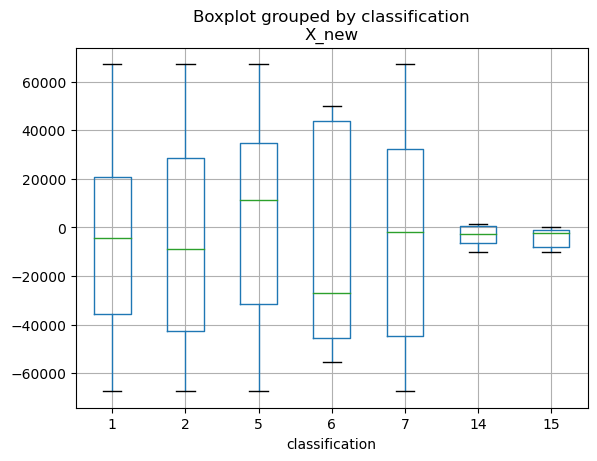

In [40]:
df.boxplot(column="X_new",by="classification")

[44206 47885 50131 49538 43728 36597 32729 31799 31509 31834 34990 38828
 39906 34989 36852 40876 48022 48316 51732 50765 47178 45843 40438 36628
 33983 35999 38505 41745 45243 42341]
[-67424.8283205 -62937.5283205 -58450.2283205 -53962.9283205
 -49475.6283205 -44988.3283205 -40501.0283205 -36013.7283205
 -31526.4283205 -27039.1283205 -22551.8283205 -18064.5283205
 -13577.2283205  -9089.9283205  -4602.6283205   -115.3283205
   4371.9716795   8859.2716795  13346.5716795  17833.8716795
  22321.1716795  26808.4716795  31295.7716795  35783.0716795
  40270.3716795  44757.6716795  49244.9716795  53732.2716795
  58219.5716795  62706.8716795  67194.1716795]


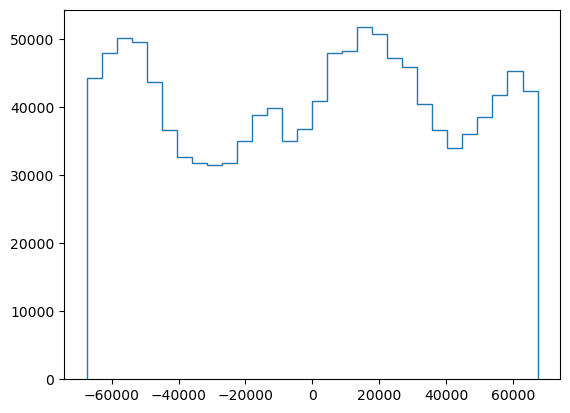

In [44]:
counts, bins = np.histogram(df.X_new,bins=30)
print(counts)
print(bins)
plt.stairs(counts, bins)

In [50]:
df.Y_new.max(),df.Y_new.min(),df.Y_new.max()-df.Y_new.min()

(31968.824505021752, -32237.175494978248, 64206.0)

<AxesSubplot: title={'center': 'Y_new'}, xlabel='classification'>

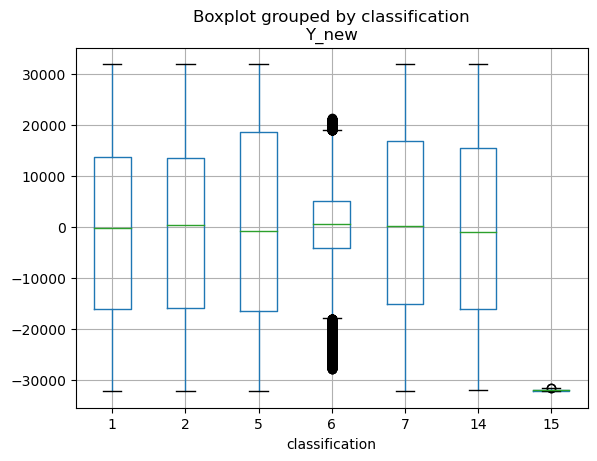

In [42]:
df.boxplot(column="Y_new",by="classification")

[41468 41767 41684 40940 40094 39876 41256 42452 42588 43221 42045 41071
 41393 40692 39758 38855 37254 36813 38093 38638 38902 40745 42386 43852
 41946 42236 43631 43096 43265 43118]
[-32237.17549498 -30096.97549498 -27956.77549498 -25816.57549498
 -23676.37549498 -21536.17549498 -19395.97549498 -17255.77549498
 -15115.57549498 -12975.37549498 -10835.17549498  -8694.97549498
  -6554.77549498  -4414.57549498  -2274.37549498   -134.17549498
   2006.02450502   4146.22450502   6286.42450502   8426.62450502
  10566.82450502  12707.02450502  14847.22450502  16987.42450502
  19127.62450502  21267.82450502  23408.02450502  25548.22450502
  27688.42450502  29828.62450502  31968.82450502]


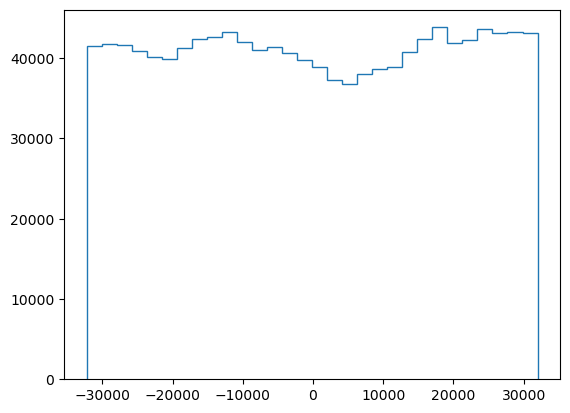

In [45]:
counts, bins = np.histogram(df.Y_new,bins=30)
print(counts)
print(bins)
plt.stairs(counts, bins)

In [51]:
df.Z_new.max(),df.Z_new.min(),df.Z_new.max()-df.Z_new.min()

(14209.060737064472, -14543.939262935528, 28753.0)

<AxesSubplot: title={'center': 'Z_new'}, xlabel='classification'>

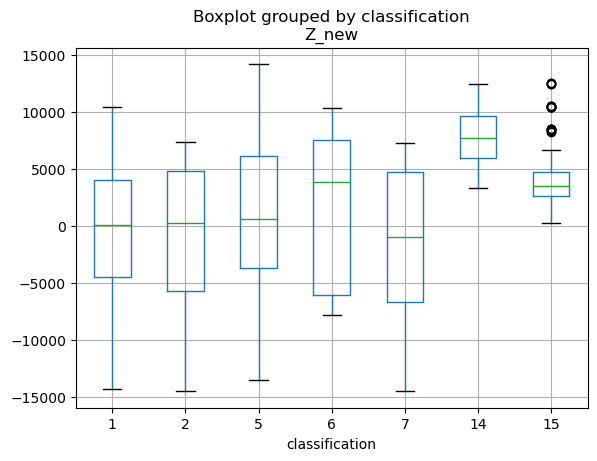

In [43]:
df.boxplot(column="Z_new",by="classification")

[ 2363 14853 20764 22443 29633 36531 33196 38369 41313 39934 44441 53336
 57817 65102 72423 78973 82247 56197 42764 44687 79905 63732 82655 60775
 33072 25911  6524  1935  1012   228]
[-14543.93926294 -13585.5059296  -12627.07259627 -11668.63926294
 -10710.2059296   -9751.77259627  -8793.33926294  -7834.9059296
  -6876.47259627  -5918.03926294  -4959.6059296   -4001.17259627
  -3042.73926294  -2084.3059296   -1125.87259627   -167.43926294
    790.9940704    1749.42740373   2707.86073706   3666.2940704
   4624.72740373   5583.16073706   6541.5940704    7500.02740373
   8458.46073706   9416.8940704   10375.32740373  11333.76073706
  12292.1940704   13250.62740373  14209.06073706]


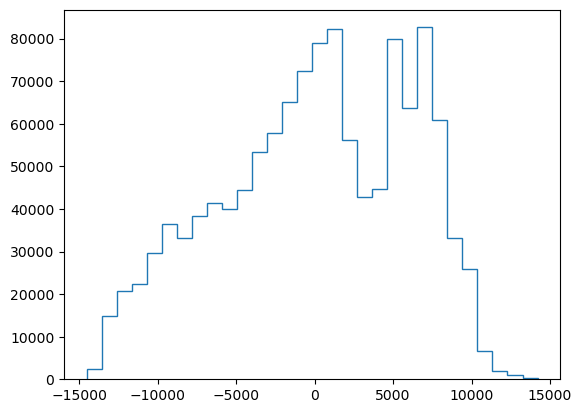

In [46]:
counts, bins = np.histogram(df.Z_new,bins=30)
print(counts)
print(bins)
plt.stairs(counts, bins)

In [37]:
subset1 = np.array(df[["X_new","Y_new","Z_new"]])
subset11 = np.array(df[["x","y","z"]])
subset111 = np.array(df[["X","Y","Z"]])
visualize_las(classified_points=subset1, df= df[["X","Y","Z"]])

entered df


In [211]:
df_2["X_new"] = (df_2.X - 0.92*df.X.mean())
df_2["Y_new"] = (df_2.Y - 0.92*df.Y.mean())
df_2["Z_new"] = (df_2.Z + 0.15*df.Z.mean())

In [51]:
df_2["X_new"] = (df_2.X + 0*(df.X.max()-df.X.min()))
df_2["Y_new"] = (df_2.Y + 3.25*(df.Y.max()-df.Y.min()))
df_2["Z_new"] = (df_2.Z + 0.05*(df.Z.max()-df.Z.min()))

In [39]:
subset2 = np.array(df_2[["X_new","Y_new","Z_new"]])
subset21 = np.array(df_2[["x","y","z"]])
visualize_las(classified_points=subset2)

did not enter df


In [52]:
df_3 = pd.concat([df,df_2])

In [53]:
subset3 = np.array(df_3[["X_new","Y_new","Z_new"]])
subset31 = np.array(df_3[["x","y","z"]])
visualize_las(classified_points=subset3)

did not enter df


In [35]:
#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=df.X[0], origin=[df.X.mean(), df.Y.mean(), df.Z.mean()])

        ## Add coordinate frames for the system. 
        # One at the origin of the dataset
        # One at the centralized mean (centroid) of the entire point cloud.
        size=100000
        coord_origin = o3d.geometry.TriangleMesh().create_coordinate_frame(size=size, origin=[0,0,0])
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=size, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10, origin=[0,0,0])
        o3d.visualization.draw_geometries([coord,coord_origin,geom])
        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter coordinate frame")